# Data Ingest

This section reads in the training, weather, holiday and metadata for all Sites across datasets

In [40]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import logging
from tqdm import tqdm
from sqlalchemy import create_engine
from utilities import convert_to_date, convert_to_int, convert_to_float, timestamp_to_int
from utilities import get_year, get_month, string_to_timestamp, timestamp_to_string
from utilities import meter_desc_mapper, activity_mapper, holidays_mapper
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix

In [6]:
holidays = pd.read_csv('data/power-laws-detecting-anomalies-in-usage-holidays.csv', sep=';')
weather = pd.read_csv('data/power-laws-detecting-anomalies-in-usage-weather.csv', sep=';')
consumption = pd.read_csv('data/power-laws-detecting-anomalies-in-usage-training-data.csv', sep=';')
metadata = pd.read_csv('data/power-laws-detecting-anomalies-in-usage-metadata.csv', sep=';')

Data filtered for Site 38

In [7]:
holidays_38 = holidays[holidays['site_id'] == '038']
weather_38 = weather[weather['site_id'] == 38]
meters = ['38_10106', '38_10107', '38_10108', '38_10109', '38_10110', '38_10111', '38_10112']
consumption_38 = consumption[consumption['meter_id'].isin(meters)]
metadata_38 = metadata[metadata['meter_id'].isin(meters)]

# Data Wrangle
This section merges the holidays, weather, consumption and metadata for Site 38

In [8]:
holidays_38.groupby('site_id').count()

,Date,Holiday
site_id,,
038,99,99


In [9]:
weather_38.groupby('site_id').count()
weather_38['Date'] = weather_38['Timestamp'].apply(convert_to_date)
weather_38.head(5)

,Timestamp,Temperature,Distance,site_id,Date
0,2012-06-21T04:00:00-04:00,19.9,11.902932,38.0,2012-06-21
1,2012-06-23T15:00:00-04:00,26.6,11.902932,38.0,2012-06-23
2,2012-06-24T05:00:00-04:00,19.4,11.902932,38.0,2012-06-24
3,2012-06-24T13:00:00-04:00,28.7,11.902932,38.0,2012-06-24
4,2012-06-25T15:00:00-04:00,25.7,11.902932,38.0,2012-06-25


In [10]:
consumption_38.groupby('meter_id').count()

,Timestamp,Values
meter_id,,
38_10106,254641,248984
38_10107,254641,223517
38_10108,254641,249674
38_10109,254641,249672
38_10110,254641,249561
38_10111,254641,246761
38_10112,254641,247263


In [11]:
metadata_38.groupby('meter_id').count()
metadata_38

,site_id,meter_id,meter_description,units,surface,activity
24,038,38_10107,laboratory,kWh,NaN,laboratory
25,038,38_10110,other,kWh,NaN,laboratory
26,038,38_10111,cold group,kWh,NaN,laboratory
38,038,38_10106,guardhouse,kWh,NaN,laboratory
39,038,38_10112,compressed air,kWh,NaN,laboratory
61,038,38_10108,laboratory,kWh,NaN,laboratory
142,038,38_10109,lighting,kWh,NaN,laboratory


In [12]:
weather_holiday = pd.merge(holidays_38, weather_38,
                           on='Date', how='outer')
weather_holiday = weather_holiday.drop_duplicates(subset='Timestamp', keep="last")
(weather_holiday.groupby('Timestamp', as_index=False)['Date']
   .agg({'count': 'count'})
   .query('count > 1'))
years = ['2012', '2013', '2014', '2015', '2016', '2017']
weather_holiday['Year'] = weather_holiday['Date'].apply(get_year)
weather_holiday['Month'] = weather_holiday['Date'].apply(get_month)
weather_holiday = weather_holiday[weather_holiday['Year'].isin(years)]
weather_holiday.drop('site_id_y', inplace=True, axis=1)
weather_holiday.groupby('Year').count()

,Date,Holiday,site_id_x,Timestamp,Temperature,Distance,Month
Year,,,,,,,
2012,8535,264,264,8535,8535,8535,8535
2013,8646,263,263,8646,8646,8646,8646
2014,8420,247,247,8420,8420,8420,8420
2015,8572,246,246,8572,8572,8572,8572
2016,8710,245,245,8710,8710,8710,8710
2017,8271,218,218,8271,8271,8271,8271


In [13]:
consumption_metadata = pd.merge(consumption_38, metadata_38,
                                on='meter_id', how='outer')

In [14]:
"""
weather_holiday_final = pd.DataFrame()
for timestamp in weather_holiday['Timestamp'].tolist():
    weather_holiday_interim = weather_holiday[weather_holiday['Timestamp'] == timestamp]
    weather_holiday_interim['Timestamp'] = weather_holiday_interim['Timestamp'].apply(string_to_timestamp)
    weather_holiday_interim = weather_holiday_interim.reindex(np.repeat(weather_holiday_interim.index.values, 4), method='ffill')
    weather_holiday_interim['Timestamp'] += pd.TimedeltaIndex([0,15,30,45], unit='m')
    weather_holiday_final = weather_holiday_final.append(weather_holiday_interim, ignore_index=True)
weather_holiday_final.to_csv("data/power-laws-weather-holiday.csv", index=False)
weather_holiday_final.head(100)
"""

'\nweather_holiday_final = pd.DataFrame()\nfor timestamp in weather_holiday[\'Timestamp\'].tolist():\n    weather_holiday_interim = weather_holiday[weather_holiday[\'Timestamp\'] == timestamp]\n    weather_holiday_interim[\'Timestamp\'] = weather_holiday_interim[\'Timestamp\'].apply(string_to_timestamp)\n    weather_holiday_interim = weather_holiday_interim.reindex(np.repeat(weather_holiday_interim.index.values, 4), method=\'ffill\')\n    weather_holiday_interim[\'Timestamp\'] += pd.TimedeltaIndex([0,15,30,45], unit=\'m\')\n    weather_holiday_final = weather_holiday_final.append(weather_holiday_interim, ignore_index=True)\nweather_holiday_final.to_csv("data/power-laws-weather-holiday.csv", index=False)\nweather_holiday_final.head(100)\n'

In [15]:
weather_holiday_dataset = pd.read_csv('data/power-laws-weather-holiday.csv')
weather_holiday_dataset.head(5)

,Date,Holiday,site_id_x,Timestamp,Temperature,Distance,Year,Month
0,2016-05-05,Ascension Thursday,38.0,2016-05-05 04:00:00,5.9,11.902932,2016,5
1,2016-05-05,Ascension Thursday,38.0,2016-05-05 04:15:00,5.9,11.902932,2016,5
2,2016-05-05,Ascension Thursday,38.0,2016-05-05 04:30:00,5.9,11.902932,2016,5
3,2016-05-05,Ascension Thursday,38.0,2016-05-05 04:45:00,5.9,11.902932,2016,5
4,2016-05-05,Ascension Thursday,38.0,2016-05-05 08:00:00,7.9,11.902932,2016,5


In [16]:
consumption_metadata['Date'] = consumption_metadata['Timestamp'].apply(convert_to_date)
consumption_metadata['Year'] = consumption_metadata['Date'].apply(get_year)

In [17]:
consumption_metadata['Timestamp'] = consumption_metadata['Timestamp'].apply(string_to_timestamp)
consumption_metadata = consumption_metadata[consumption_metadata['Year'].isin(years)]
consumption_metadata.head(10)

,meter_id,Timestamp,Values,site_id,meter_description,units,surface,activity,Date,Year
16,38_10107,2012-01-01 17:30:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
17,38_10107,2012-01-01 19:00:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
18,38_10107,2012-01-01 21:45:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
19,38_10107,2012-01-01 23:15:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
20,38_10107,2012-01-02 03:15:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
21,38_10107,2012-01-02 16:00:00,-74614.0,038,laboratory,kWh,NaN,laboratory,2012-01-02,2012
22,38_10107,2012-01-03 00:15:00,-74614.0,038,laboratory,kWh,NaN,laboratory,2012-01-02,2012
23,38_10107,2012-01-03 01:00:00,-74614.0,038,laboratory,kWh,NaN,laboratory,2012-01-02,2012
24,38_10107,2012-01-03 01:15:00,-74614.0,038,laboratory,kWh,NaN,laboratory,2012-01-02,2012
25,38_10107,2012-01-03 12:00:00,-74597.0,038,laboratory,kWh,NaN,laboratory,2012-01-03,2012


In [18]:
consumption_metadata['Timestamp'] = consumption_metadata['Timestamp'].apply(timestamp_to_string)

In [19]:
consumption_metadata.head(5)

,meter_id,Timestamp,Values,site_id,meter_description,units,surface,activity,Date,Year
16,38_10107,2012-01-01 17:30:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
17,38_10107,2012-01-01 19:00:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
18,38_10107,2012-01-01 21:45:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
19,38_10107,2012-01-01 23:15:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012
20,38_10107,2012-01-02 03:15:00,-74622.0,038,laboratory,kWh,NaN,laboratory,2012-01-01,2012


In [20]:
consumption_metadata_null = consumption_metadata[consumption_metadata['Values'].isna()]
consumption_metadata_null.count()

meter_id             61490
Timestamp            61490
Values                   0
site_id              61490
meter_description    61490
units                61490
surface                  0
activity             61490
Date                 61490
Year                 61490
dtype: int64

### Merge Consumption, Metadata, Weather, Holiday

In [21]:
consumption_weather = pd.merge(consumption_metadata, weather_holiday_dataset,
                               on='Timestamp', how='inner')
# consumption_weather = consumption_weather[consumption_weather['Year_x'] == '2014']
columns = ['site_id_x', 'Date_y', 'Year_y', 'surface']
consumption_weather.drop(columns, inplace=True, axis=1)
consumption_weather.count()

meter_id             1424528
Timestamp            1424528
Values               1364879
site_id              1424528
meter_description    1424528
units                1424528
activity             1424528
Date_x               1424528
Year_x               1424528
Holiday                41524
Temperature          1424528
Distance             1424528
Month                1424528
dtype: int64

In [22]:
consumption_weather.head(10)

,meter_id,Timestamp,Values,site_id,meter_description,units,activity,Date_x,Year_x,Holiday,Temperature,Distance,Month
0,38_10107,2012-01-01 17:30:00,-7.462200e+04,038,laboratory,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
1,38_10108,2012-01-01 17:30:00,3.994762e+06,038,laboratory,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
2,38_10109,2012-01-01 17:30:00,1.474846e+06,038,lighting,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
3,38_10106,2012-01-01 17:30:00,8.891660e+05,038,guardhouse,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
4,38_10110,2012-01-01 17:30:00,1.108886e+07,038,other,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
5,38_10111,2012-01-01 17:30:00,4.474658e+05,038,cold group,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
6,38_10112,2012-01-01 17:30:00,1.074890e+05,038,compressed air,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1
7,38_10107,2012-01-01 19:00:00,-7.462200e+04,038,laboratory,kWh,laboratory,2012-01-01,2012,New year,4.9,11.902932,1
8,38_10108,2012-01-01 19:00:00,3.994793e+06,038,laboratory,kWh,laboratory,2012-01-01,2012,New year,4.9,11.902932,1
9,38_10109,2012-01-01 19:00:00,1.474846e+06,038,lighting,kWh,laboratory,2012-01-01,2012,New year,4.9,11.902932,1


In [23]:
consumption_weather['site_id'] = 38
consumption_weather['Year_x'] = consumption_weather['Year_x'].apply(convert_to_int)
consumption_weather['meter_id'] = consumption_weather['meter_id'].apply(convert_to_int)
consumption_weather['Timestamp'] = consumption_weather['Timestamp'].apply(string_to_timestamp)
consumption_weather['Date_x'] = consumption_weather['Date_x'].apply(string_to_timestamp)
consumption_weather['Timestamp_numeric'] = consumption_weather['Timestamp'].apply(timestamp_to_int)
consumption_weather['Date_numeric'] = consumption_weather['Date_x'].apply(timestamp_to_int)

In [24]:
"""
cols_to_transform = [ 'meter_description', 'activity', 'Holiday']

def MultiLabelEncoder(cols_to_transform, consumption_weather):
    for column in cols_to_transform:
        le = LabelEncoder()
        consumption_weather[column+'_numeric'] = le.fit_transform(consumption_weather[column])

MultiLabelEncoder(cols_to_transform, consumption_weather)
"""

"\ncols_to_transform = [ 'meter_description', 'activity', 'Holiday']\n\ndef MultiLabelEncoder(cols_to_transform, consumption_weather):\n    for column in cols_to_transform:\n        le = LabelEncoder()\n        consumption_weather[column+'_numeric'] = le.fit_transform(consumption_weather[column])\n\nMultiLabelEncoder(cols_to_transform, consumption_weather)\n"

In [25]:
consumption_weather.head(5)

,meter_id,Timestamp,Values,site_id,meter_description,units,activity,Date_x,Year_x,Holiday,Temperature,Distance,Month,Timestamp_numeric,Date_numeric
0,3810107,2012-01-01 17:30:00,-74622.0,38,laboratory,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000
1,3810108,2012-01-01 17:30:00,3994762.0,38,laboratory,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000
2,3810109,2012-01-01 17:30:00,1474846.0,38,lighting,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000
3,3810106,2012-01-01 17:30:00,889166.0,38,guardhouse,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000
4,3810110,2012-01-01 17:30:00,11088862.0,38,other,kWh,laboratory,2012-01-01,2012,New year,8.5,11.902932,1,1325457000,1325394000


In [26]:
consumption_weather.isna().sum()

meter_id                   0
Timestamp                  0
Values                 59649
site_id                    0
meter_description          0
units                      0
activity                   0
Date_x                     0
Year_x                     0
Holiday              1383004
Temperature                0
Distance                   0
Month                      0
Timestamp_numeric          0
Date_numeric               0
dtype: int64

In [27]:
consumption_values_null = consumption_weather[consumption_weather['Values'].isna()]
consumption_values_null.groupby("meter_id").count()

,Timestamp,Values,site_id,meter_description,units,activity,Date_x,Year_x,Holiday,Temperature,Distance,Month,Timestamp_numeric,Date_numeric
meter_id,,,,,,,,,,,,,,
3810106,5179,0,5179,5179,5179,5179,5179,5179,195,5179,5179,5179,5179,5179
3810107,26565,0,26565,26565,26565,26565,26565,26565,845,26565,26565,26565,26565,26565
3810108,4521,0,4521,4521,4521,4521,4521,4521,195,4521,4521,4521,4521,4521
3810109,4523,0,4523,4523,4523,4523,4523,4523,196,4523,4523,4523,4523,4523
3810110,4634,0,4634,4634,4634,4634,4634,4634,196,4634,4634,4634,4634,4634
3810111,7308,0,7308,7308,7308,7308,7308,7308,268,7308,7308,7308,7308,7308
3810112,6919,0,6919,6919,6919,6919,6919,6919,268,6919,6919,6919,6919,6919


In [28]:
consumption_weather.to_csv("data/power-laws-energy-consumption-dataset.csv", index=False)

In [29]:
consumption_weather = pd.read_csv("data/power-laws-energy-consumption-dataset.csv")

In [30]:
consumption_weather['meter_description_numeric'] = consumption_weather['meter_description'].apply(meter_desc_mapper)
consumption_weather['activity_numeric'] = consumption_weather['activity'].apply(activity_mapper)
consumption_weather['Holiday_numeric'] = consumption_weather['Holiday'].apply(holidays_mapper)

In [37]:
consumption_weather.to_csv("data/power-laws-energy-consumption-dataset.csv", index=False)

In [31]:
consumption_weather.head(5)

,meter_id,Timestamp,Values,site_id,meter_description,units,activity,Date_x,Year_x,Holiday,Temperature,Distance,Month,Timestamp_numeric,Date_numeric,meter_description_numeric,activity_numeric,Holiday_numeric
0,3810107,2012-01-01 17:30:00,-74622.0,38,laboratory,kWh,laboratory,2012-01-01 00:00:00,2012,New year,8.5,11.902932,1,1325457000,1325394000,1,1,3.0
1,3810108,2012-01-01 17:30:00,3994762.0,38,laboratory,kWh,laboratory,2012-01-01 00:00:00,2012,New year,8.5,11.902932,1,1325457000,1325394000,1,1,3.0
2,3810109,2012-01-01 17:30:00,1474846.0,38,lighting,kWh,laboratory,2012-01-01 00:00:00,2012,New year,8.5,11.902932,1,1325457000,1325394000,2,1,3.0
3,3810106,2012-01-01 17:30:00,889166.0,38,guardhouse,kWh,laboratory,2012-01-01 00:00:00,2012,New year,8.5,11.902932,1,1325457000,1325394000,3,1,3.0
4,3810110,2012-01-01 17:30:00,11088862.0,38,other,kWh,laboratory,2012-01-01 00:00:00,2012,New year,8.5,11.902932,1,1325457000,1325394000,4,1,3.0


In [54]:
type(consumption_weather['Holiday_numeric'][0])

numpy.float64

In [43]:
consumption_weather = consumption_weather[['meter_id', 'Values', 'Year_x', 'Temperature', 'Distance', 'Month', 'Timestamp_numeric', 'Date_numeric', 'meter_description_numeric', 'activity_numeric', 'Holiday_numeric']]
consumption_weather.head(5)

,meter_id,Values,Year_x,Temperature,Distance,Month,Timestamp_numeric,Date_numeric,meter_description_numeric,activity_numeric,Holiday_numeric
0,3810107,-74622.0,2012,8.5,11.902932,1,1325457000,1325394000,1,1,3.0
1,3810108,3994762.0,2012,8.5,11.902932,1,1325457000,1325394000,1,1,3.0
2,3810109,1474846.0,2012,8.5,11.902932,1,1325457000,1325394000,2,1,3.0
3,3810106,889166.0,2012,8.5,11.902932,1,1325457000,1325394000,3,1,3.0
4,3810110,11088862.0,2012,8.5,11.902932,1,1325457000,1325394000,4,1,3.0


LinAlgError: singular matrix

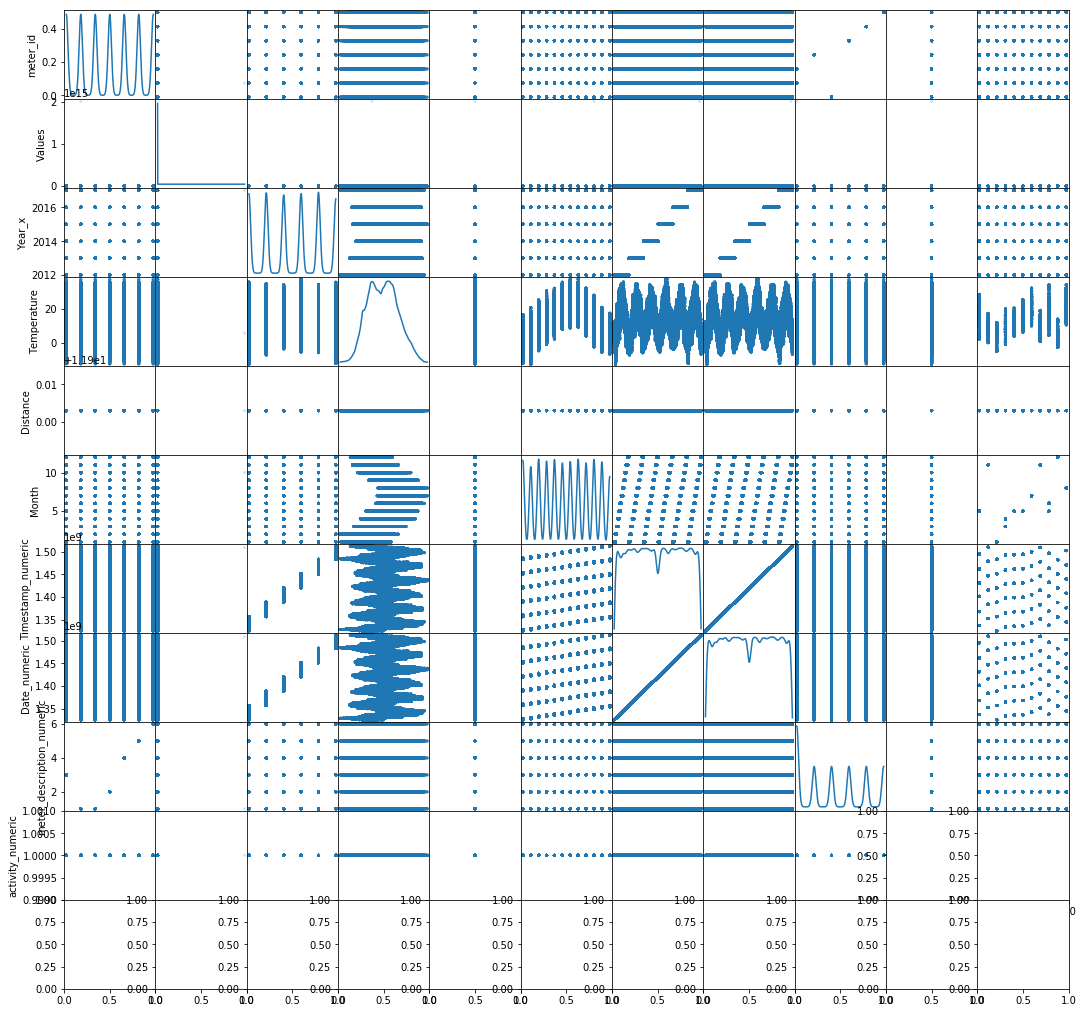

In [55]:
scatter_matrix(consumption_weather, alpha=0.2, figsize=(18,18), diagonal='kde')
plt.show()

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [34]:
"""
X = consumption_weather[["Timestamp", "meter_id", "Date_x", "Holiday", "Temperature", "Distance"]]
y = consumption_weather["Values"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)
log_reg = lr.fit(X_train, y_train)
"""

'\nX = consumption_weather[["Timestamp", "meter_id", "Date_x", "Holiday", "Temperature", "Distance"]]\ny = consumption_weather["Values"]\nX_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25)\nlog_reg = lr.fit(X_train, y_train)\n'

In [35]:
# Every estimator has a score method that can judge the quality of the 
# fit (or the prediction) on new data. Bigger is better.   
# log_reg.score(X_test, y_test)